In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

with zipfile.ZipFile('/content/drive/MyDrive/AI Masters/DL/dl-2020-unibuc-nlp.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
import os, glob, re, random

import pandas as pd
import numpy as np

from nltk.stem.porter import *

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

In [ ]:
def compute_accuracy(predictions, labels):
    predictions = np.argmax(predictions, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(predictions == labels) / len(labels)

def train_model(model, train_dataloader, validation_dataloader, model_name,
                epochs = 10, seed_val=42, num_warmup_steps=0):
    training_stats = []

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    num_training_steps = len(train_dataloader) * epochs

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = num_warmup_steps,
                                                num_training_steps = num_training_steps)

    saved_model_accuracy = -1
    saved_model_loss = 1000

    cross_entropy_loss = nn.CrossEntropyLoss()

    for epoch_i in range(0, epochs):
        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            output = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
            loss = cross_entropy_loss(output.logits, b_labels)
            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        if validation_dataloader is not None:
            for batch in validation_dataloader:

                b_input_ids = batch[0].to(device)
                b_input_mask = batch[1].to(device)
                b_labels = batch[2].to(device)
                
                with torch.no_grad():        

                    output = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
                    loss = cross_entropy_loss(output.logits, b_labels)
                    
                total_eval_loss += loss.item()

                logits = output.logits.detach().cpu().numpy()
                label_ids = b_labels.to('cpu').numpy()

                total_eval_accuracy += compute_accuracy(logits, label_ids)
                
            avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
            avg_val_loss = total_eval_loss / len(validation_dataloader)
            
            print("Epoch {} / {}: Average training loss: {:.4f}, Validation Acc: {:.4f}, Validation Loss: {:.4f}.".
                format(epoch_i + 1, epochs, avg_train_loss, avg_val_accuracy, avg_val_loss))
            
            if saved_model_loss > (avg_val_loss - 0.001):
                fileList = glob.glob('/content/' + model_name + '*')
                if len(fileList) != 0:
                    os.remove(fileList[0])
                torch.save(model.state_dict(), '/content/' + model_name + str(avg_val_accuracy))
                saved_model_accuracy = avg_val_accuracy
                saved_model_loss = avg_val_loss
            
            training_stats.append({'epoch': epoch_i + 1, 'Training Loss': avg_train_loss,
                                   'Val Loss': avg_val_loss, 'Val Acc': avg_val_accuracy})
        else:
            print("Epoch {} / {}: Average training loss: {:.4f}.".format(epoch_i + 1, epochs, avg_train_loss))
        
    return model, training_stats

def tokenize_data(tokenizer, df):
    input_ids = []
    attention_masks = []
    labels = []
    indexed_tokens = []

    for index, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(row['text'], 
                                             add_special_tokens=True, 
                                             max_length = 128, #try 256, 512
                                             padding = 'max_length',
                                             truncation=True,
                                             return_attention_mask=True,
                                             return_tensors='pt')
        
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(row['target'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    return input_ids, attention_masks, labels

def sample_data(df):
    df_sample = pd.DataFrame(columns = ['sid', 'target', 'text']) 

    selected_dfs = {4: df[df['target'] == 4].sample(4), 
                    5: df[df['target'] == 5].sample(5),
                    2: df[df['target'] == 2].sample(7),
                    3: df[df['target'] == 3].sample(8),
                    9: df[df['target'] == 9].sample(8), 
                    1: df[df['target'] == 1].sample(8),
                    7: df[df['target'] == 7].sample(8),
                    0: df[df['target'] == 0].sample(9),
                    8: df[df['target'] == 8].sample(11), 
                    6: df[df['target'] == 6].sample(12)}

    for key, value in selected_dfs.items():
        df_sample = df_sample.append(value)
        df = df.drop(list(value.index))

    return df_sample, df

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])

df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)
df['target'] = df['target'].map(lambda x: x - 1)

## SGD Baseline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])

df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], 
                                                    test_size=100,
                                                    random_state = 42)

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-4, 
                                      random_state=42, max_iter=3, tol=None)),
                ])

sgd.fit(X_train, y_train)

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.81


## MLP

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])

df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['target'], 
                                                    test_size=80,
                                                    random_state = 42)

mlp = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(random_state=1, learning_rate='invscaling')),
            ])

mlp.fit(X_train, y_train)   

y_pred = mlp.predict(X_test)

acc = accuracy_score(list(y_pred), list(y_test))
print('Accuracy {}.'.format(acc))

Accuracy 0.875.


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:573: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(list(y_pred), list(y_test), output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
1,0.900000,0.818182,0.857143,11.0000
2,0.833333,1.000000,0.909091,5.0000
3,0.875000,1.000000,0.933333,7.0000
4,0.714286,0.833333,0.769231,6.0000
5,1.000000,0.666667,0.800000,3.0000
6,0.900000,1.000000,0.947368,9.0000
7,0.923077,0.857143,0.888889,14.0000
8,1.000000,1.000000,1.000000,4.0000
9,1.000000,0.916667,0.956522,12.0000
10,0.777778,0.777778,0.777778,9.0000


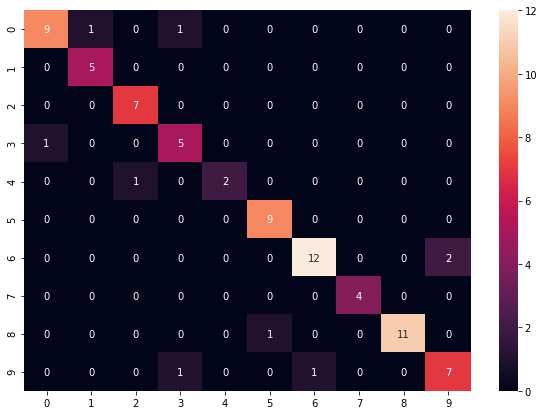

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(list(y_pred), list(y_test))
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## BERT Romanian

Using [dumitrescustefan/bert-base-romanian-cased-v1](https://huggingface.co/dumitrescustefan/bert-base-romanian-cased-v1).

In [ ]:
!pip install sentencepiece
!pip install transformers

In [ ]:
import torch
import torch.optim as optim

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
MODEL_NAME = "dumitrescustefan/bert-base-romanian-cased-v1"

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])

df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)
df['target'] = df['target'].map(lambda x: x - 1)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, 
                                          do_lower_case = True)

In [ ]:
val_df, df = sample_data(df)
test_df, df = sample_data(df)

input_ids, attention_masks, labels = tokenize_data(tokenizer, df)
train_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, val_df)
val_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, test_df)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

print('Training samples: {}.'.format(len(train_dataset)))
print('Validation samples: {}.'.format(len(val_dataset)))
print('Test samples: {}.'.format(len(test_dataset)))

2,914 training samples
   80 validation samples
   80 test samples


In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
model, training_stats = train_model(model, 
                                    train_dataloader, validation_dataloader, 
                                    epochs=35, seed_val=42, model_name='romanian-bert-')

In [ ]:
model.load_state_dict(torch.load('/content/romanian-bert-0.859375'))

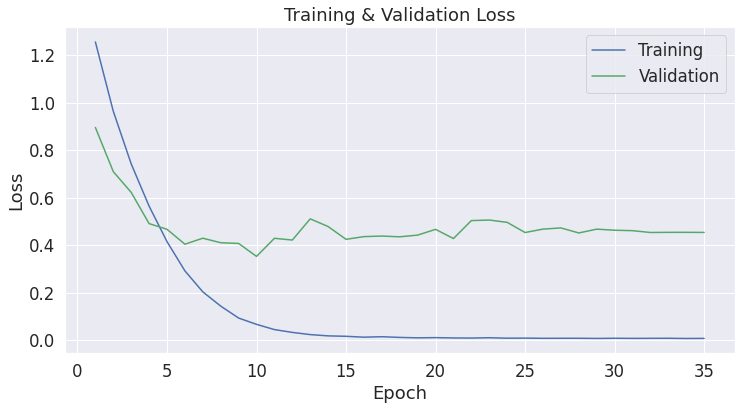

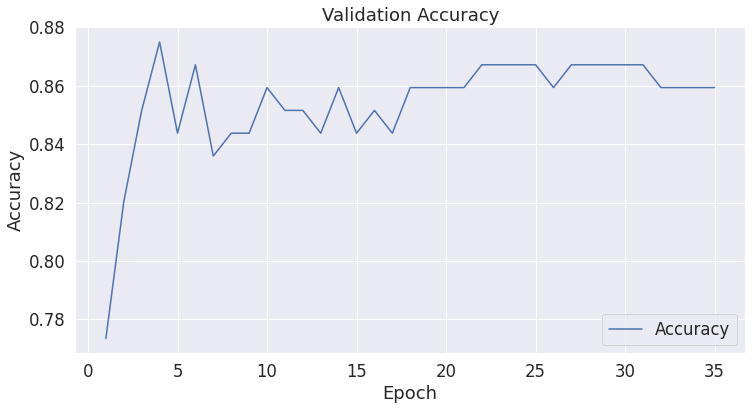

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b', label="Training")
plt.plot(df_stats['Val Loss'], 'g', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(df_stats['Val Acc'], 'b', label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    label_ids = b_labels.to('cpu').numpy()
    test_predictions.append(torch.argmax(logits).item())
    true_labels.append(label_ids)

accuracy_score(true_labels, test_predictions)

0.8

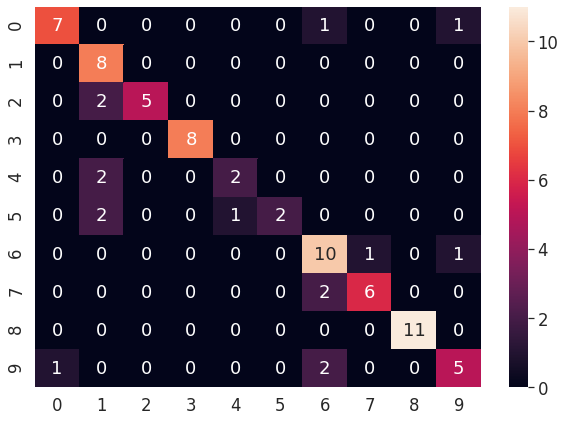

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## BERT English

Using data transalted with Azure Cognitive Services.

In [ ]:
!pip install transformers

In [ ]:
import torch
import torch.optim as optim

from torch.nn import functional as F
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
MODEL_NAME = "bert-base-uncased"

In [ ]:
def get_translation(text_input, language_input, language_output):
    base_url = 'https://api.cognitive.microsofttranslator.com'
    path = '/translate?api-version=3.0'
    params = '&to=' + language_output + '&from=' + language_input
    constructed_url = base_url + path + params

    headers = {
        'Ocp-Apim-Subscription-Key': 'somekey',
        'Ocp-Apim-Subscription-Region': 'northeurope',
        'Content-type': 'application/json',
        'X-ClientTraceId': str(uuid.uuid4())
    }

    body = [{'text' : text_input}]
    response = requests.post(constructed_url, headers=headers, json=body)
    return str(response.json()[0]['translations'][0]['text'])


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/AI Masters/DL/data_english.csv')

df = df.drop(['Unnamed: 0'], axis=1)
df['text'] = df['text'].astype(str)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, 
                                          do_lower_case = False)

In [ ]:
val_df, df = sample_data(df)
test_df, df = sample_data(df)

input_ids, attention_masks, labels = tokenize_data(tokenizer, df)
train_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, val_df)
val_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, test_df)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

print('Training samples: {}.'.format(len(train_dataset)))
print('Validation samples: {}.'.format(len(val_dataset)))
print('Test samples: {}.'.format(len(test_dataset)))

In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
model, training_stats = train_model(model, 
                                    train_dataloader, validation_dataloader, 
                                    epochs=35, seed_val=2000, model_name='english-bert-')

In [ ]:
model.load_state_dict(torch.load('/content/english-bert-0.640625'))

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b', label="Training")
plt.plot(df_stats['Val Loss'], 'g', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(df_stats['Val Acc'], 'b', label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    label_ids = b_labels.to('cpu').numpy()
    test_predictions.append(torch.argmax(logits).item())
    true_labels.append(label_ids)

accuracy_score(true_labels, test_predictions)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## XLM - RoBERTa

todo: try ensemble model

In [ ]:
!pip install sentencepiece
!pip install transformers

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from transformers import get_cosine_schedule_with_warmup

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

MODEL_NAME = 'xlm-roberta-base'
VOCABULARY_PATH = 'https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model'

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])
df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)
df['target'] = df['target'].map(lambda x: x - 1)
print(pd.DataFrame([df['target'].value_counts()]))

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME,
                                                do_lower_case = False)

          6    8    0    7    1    9    3    2    5    4
target  455  424  346  317  306  303  297  262  203  161


In [ ]:
val_df, df = sample_data(df)
test_df, df = sample_data(df)

input_ids, attention_masks, labels = tokenize_data(tokenizer, df)
train_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, val_df)
val_dataset = TensorDataset(input_ids, attention_masks, labels)

input_ids, attention_masks, labels = tokenize_data(tokenizer, test_df)
test_dataset = TensorDataset(input_ids, attention_masks, labels)

print('Training samples: {}.'.format(len(train_dataset)))
print('Validation samples: {}.'.format(len(val_dataset)))
print('Test samples: {}.'.format(len(test_dataset)))

Training samples: 2914.
Validation samples: 80.
Test samples: 80.


In [ ]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = XLMRobertaForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels = 10,  
    output_attentions = False,
    output_hidden_states = False)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
model, training_stats = train_model(model, 
                                    train_dataloader, validation_dataloader, 
                                    epochs=35, seed_val=2000, model_name=MODEL_NAME  + '-')

In [ ]:
model.load_state_dict(torch.load('/content/xlm-roberta-base-0.7421875'))

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-', label="Training")
plt.plot(df_stats['Val Loss'], 'g-', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(df_stats['Val Acc'], 'b-', label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  label_ids = b_labels.to('cpu').numpy()
  test_predictions.append(torch.argmax(logits).item())
  true_labels.append(label_ids.item())

print(accuracy_score(true_labels, test_predictions))

0.825


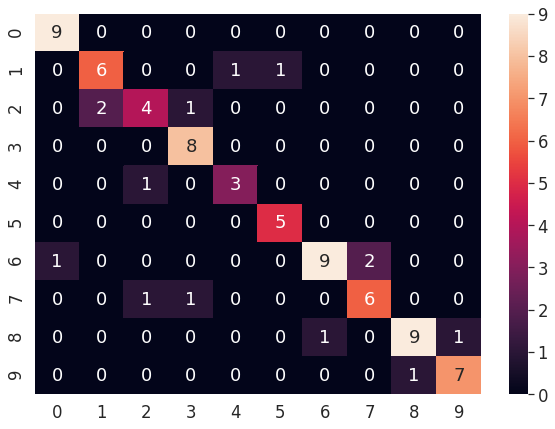

In [ ]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, test_predictions)
df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(10)], columns=[i for i in range(10)])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

## XLM - RoBERTa Language Model + Sequence Classification

In [ ]:
!pip install sentencepiece
!pip install transformers

     |████████████████████████████████| 1.1MB 6.7MB/s 
     |████████████████████████████████| 1.5MB 6.7MB/s 
     |████████████████████████████████| 890kB 33.0MB/s 
     |████████████████████████████████| 2.9MB 40.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=73383f1fdb72f23e181b8c9ac372d0f1f0ec21872a9a0997aa3104004c93318f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

from transformers import XLMRobertaForMaskedLM
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup

torch.set_grad_enabled(True)
if torch.cuda.is_available(): 
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

MODEL_NAME = 'xlm-roberta-base'
VOCABULARY_PATH = 'https://huggingface.co/xlm-roberta-base/resolve/main/sentencepiece.bpe.model'

In [ ]:
df_train = pd.read_csv(f"/content/train.txt", 
                       delimiter=',', names=['sid', 'target', 'text'])
df_val = pd.read_csv(f"/content/vaidation.txt", 
                     delimiter=',', names=['sid', 'target', 'text'])

df = pd.concat([df_train, df_val])
df.index = list(range(3074))
df['text'] = df['text'].astype(str)
df['target'] = df['target'].map(lambda x: x - 1)
print(pd.DataFrame([df['target'].value_counts()]))

df_lm = pd.DataFrame(columns=['target', 'text'])

for row in df.iterrows():
    mask_position = random.randint(0, len(row[1]['text'].split()) - 1)
    new_text = ' '.join(['<mask>' if word == row[1]['text'].split()[mask_position] else word for word in row[1]['text'].split()])
    df_lm = df_lm.append({'target': row[1]['text'], 'text': new_text}, ignore_index=True)

tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME, 
                                                do_lower_case = False)

          6    8    0    7    1    9    3    2    5    4
target  455  424  346  317  306  303  297  262  203  161


In [ ]:
def train_model_lm(model, train_dataloader, validation_dataloader, model_name,
                   epochs=10, seed_val=42, num_warmup_steps=0):
    training_stats = []

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    total_steps = len(train_dataloader) * epochs

    scheduler = get_cosine_schedule_with_warmup(optimizer, 
                                                num_warmup_steps = num_warmup_steps,
                                                num_training_steps = total_steps)

    saved_model_accuracy = -1
    saved_model_loss = 1000

    cross_entropy_loss = nn.CrossEntropyLoss()

    for epoch_i in range(0, epochs):
        total_train_loss = 0

        model.train()

        for step, batch in enumerate(train_dataloader):

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            output = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask, 
                           labels=b_labels)
            loss, logits = output.loss, output.logits
            # loss = cross_entropy_loss(logits, b_labels)
            total_train_loss += loss.item()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

        avg_train_loss = total_train_loss / len(train_dataloader)

        model.eval()

        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        for batch in validation_dataloader:

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            with torch.no_grad():        

                output = model(b_input_ids, 
                               token_type_ids=None, 
                               attention_mask=b_input_mask,
                               labels=b_labels)
                loss, logits = output.loss, output.logits
                # loss = cross_entropy_loss(logits, b_labels)
                
            total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            total_eval_accuracy += compute_accuracy(logits, label_ids)
            
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        print("Epoch {} / {}: Average training loss: {:.4f}, Validation Acc: {:.4f}, Validation Loss: {:.4f}.".
            format(epoch_i + 1, epochs, avg_train_loss, avg_val_accuracy, avg_val_loss))
        
        if saved_model_loss > (avg_val_loss - 0.001):
            fileList = glob.glob('/content/' + model_name + '*')
            if len(fileList) != 0:
                os.remove(fileList[0])
            torch.save(model.state_dict(), '/content/' + model_name + str(avg_val_accuracy))
            saved_model_accuracy = avg_val_accuracy
            saved_model_loss = avg_val_loss
        
        training_stats.append({'epoch': epoch_i + 1, 'Training Loss': avg_train_loss,
                               'Val Loss': avg_val_loss, 'Val Acc': avg_val_accuracy})
        
    return model, training_stats

def tokenize_data_lm(tokenizer, df):
    input_ids = []
    attention_masks = []
    labels = []
    indexed_tokens = []

    for index, row in df.iterrows():
        encoded_dict = tokenizer.encode_plus(row['text'], 
                                             add_special_tokens = True, 
                                             max_length = 128,
                                             padding = 'max_length',
                                             truncation=True,
                                             return_attention_mask = True,
                                             return_tensors = 'pt')
        label = tokenizer.encode_plus(row['target'], 
                                      add_special_tokens = True, 
                                      max_length = 128,
                                      padding = 'max_length',
                                      truncation=True,
                                      return_attention_mask = True,
                                      return_tensors = 'pt')['input_ids']
        
        input_ids.append(encoded_dict['input_ids']) 
        attention_masks.append(encoded_dict['attention_mask'])
        labels.append(torch.tensor(label))

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.cat(labels, dim=0)

    return input_ids, attention_masks, labels

input_ids, attention_masks, labels = tokenize_data_lm(tokenizer, df_lm)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME, 
                                                do_lower_case = False)
model = XLMRobertaForMaskedLM.from_pretrained(MODEL_NAME)
model.cuda()


inputs = tokenizer(df_lm['text'][10], add_special_tokens = True, 
                   max_length = 128, padding = 'max_length',
                   truncation=True, return_attention_mask = True,
                   return_tensors = 'pt')
labels = tokenizer(df_lm['target'][10], add_special_tokens = True, 
                   max_length = 128, padding = 'max_length',
                   truncation=True, return_attention_mask = True,
                   return_tensors = 'pt')['input_ids']

inputs.to(device)
labels.to(device)

outputs = model(**inputs, labels=labels)

In [ ]:
outputs

In [ ]:
dataset = TensorDataset(input_ids, attention_masks, labels)

train_size = int(0.97 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_size = int(0.97 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

2,891 training samples
   90 validation samples
   93 test samples


In [ ]:
batch_size =  1

train_dataloader = DataLoader(train_dataset, 
                              sampler = RandomSampler(train_dataset), 
                              batch_size = batch_size)

validation_dataloader = DataLoader(val_dataset,
                                   sampler = SequentialSampler(val_dataset),  
                                   batch_size = batch_size)

In [ ]:
model = XLMRobertaForMaskedLM.from_pretrained(MODEL_NAME)

optimizer = AdamW(model.parameters(), lr = 1e-5)

model.cuda()

In [ ]:
model, training_stats = train_model_lm(model, 
                                       train_dataloader, validation_dataloader, 
                                       epochs=10, seed_val=14, model_name=MODEL_NAME+'-lm-')

In [ ]:
pd.set_option('precision', 2)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-', label="Training")
plt.plot(df_stats['Val Loss'], 'g-', label="Validation")
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(df_stats['Val Acc'], 'b-', label="Accuracy")
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
test_dataloader = DataLoader(test_dataset,
                             sampler = SequentialSampler(test_dataset), 
                             batch_size = 1)

model.eval()
test_predictions , true_labels = [], []

for batch in test_dataloader:
  batch = tuple(t.to(device) for t in batch)
  b_input_ids, b_input_mask, b_labels = batch
  
  with torch.no_grad():
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]
  label_ids = b_labels.to('cpu').numpy()
  test_predictions.append(torch.argmax(logits).item())
  true_labels.append(label_ids.item())

print(accuracy_score(true_labels, test_predictions))

## Save results to txt

In [ ]:
df_test = pd.read_csv(f"/content/test.txt", 
                      delimiter=',', names=['sid', 'text'])

df_test['text'] = df_test['text'].astype(str)

test_sid = []
test_input_ids = []
test_attention_masks = []

for index, row in df_test.iterrows():
    encoded_dict = tokenizer.encode_plus(
                        row['text'], 
                        add_special_tokens = True, 
                        max_length = 128, #256, 512
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt')
    test_sid.append(row['sid'])
    test_input_ids.append(encoded_dict['input_ids'])    
    test_attention_masks.append(encoded_dict['attention_mask'])

test_sid = torch.Tensor(test_sid)
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)

prediction_data = TensorDataset(test_sid, test_input_ids, test_attention_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, 
                                   sampler=prediction_sampler, 
                                   batch_size=1)

model.eval()
predictions = []

for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_sid, b_input_ids, b_input_mask = batch
  
    with torch.no_grad():
        outputs = model(b_input_ids, token_type_ids=None, 
                        attention_mask=b_input_mask)

    logits = outputs[0]
    predictions.append((int(b_sid.item()), torch.argmax(logits).item() + 1))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2179: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
f = open('nlp_submission_roberta_10.txt', 'w')
f.write('id,label')
f.write('\n')

for sid, predicted_label in predictions:
    f.write(str(sid) + ',' + str(predicted_label))
    f.write('\n')

f.close()